In [21]:
import plotly.express as plx
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import scipy.stats as st

from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

In [2]:
DATA_PATH = "../../data/input"

# Data loading

In [3]:
df_acq = pd.read_csv(os.path.join(DATA_PATH, 'internship_acquisition_list.csv'))
#df_acq[df_acq['class'].isin(['QC']) & (df_acq['batch'] == 1)].sort_values('order')

In [4]:
df_data = pd.read_csv(os.path.join(DATA_PATH, 'internship_data_matrix.csv'))
df_feature_meta = pd.read_csv(os.path.join(DATA_PATH, 'internship_feature_metadata.csv'))

# Augment dataset with metadata
df_data = df_data.merge(df_acq[['sample', 'class', 'order', 'batch']], on='sample')
df_data = df_data.melt(id_vars=['sample', 'class', 'order', 'batch'],value_name='intensity', var_name='feature')
df_data = df_data.merge(df_feature_meta[['feature', 'mz', 'rt']], on='feature')
df_data['feature_number'] = df_data['feature'].apply(lambda s : int(s.split('-')[1]))

# Filter classes, batch of interest and mass range of interest
df_data = df_data[df_data['class'].isin(['QC', 'Dunn', 'French', 'LMU']) & df_data['batch'] == 1]
df_glycans = df_feature_meta[df_feature_meta['mz'] > 500]
df_data = df_data.merge(df_glycans['feature'], on='feature', how='inner')

# Data processing

## 1 - Select features :
* which have a limited variability across quality check samples (CV < 30%)
* which are consistently detected across samples (70%)

In [5]:
# Remove features with outliers in QC to compute robust CV on features

df_QC = df_data[df_data['class'] == 'QC']
df_QC_summary = df_QC.groupby(['feature'])['intensity'].describe().reset_index()
df_QC_summary['lower_bound'] = 2.5*df_QC_summary['25%'] - 1.5*df_QC_summary['75%']
df_QC_summary['upper_bound'] = 2.5*df_QC_summary['75%'] - 1.5*df_QC_summary['25%']
df_QC = df_QC.merge(df_QC_summary[['feature', 'lower_bound', 'upper_bound']], on='feature')
print(f"Each QC sample has at least 1 outliers :\n{df_QC[(df_QC['intensity'] < df_QC['lower_bound']) | (df_QC['intensity'] > df_QC['upper_bound']) ].groupby('sample').size()}.")

# Since the features first selection step relies on CV per feature, we can just remove feature with outlier value for each sample
df_QC = df_QC[(df_QC['intensity'] >= df_QC['lower_bound']) & (df_QC['intensity'] <= df_QC['upper_bound']) ]

Each QC sample has at least 1 outliers :
sample
20241106-297-QC1      6
20241106-297-QC10     9
20241106-297-QC11     5
20241106-297-QC2     37
20241106-297-QC3      1
20241106-297-QC4      2
20241106-297-QC6     39
20241106-297-QC7     32
20241106-297-QC8      1
20241106-297-QC9      4
dtype: int64.


In [6]:
# Compute CV

cv_QC = df_QC.groupby('feature')['intensity'].agg(lambda x : x.std() / x.mean() * 100).reset_index().rename(columns={'intensity' : 'CV%'})
cv_QC.describe()

,CV%
count,248.000000
mean,20.206194
std,12.235200
min,2.416975
25%,14.056512
50%,17.015310
75%,22.907125
max,99.131709


According to [Instrumental Drift in Untargeted Metabolomics: Optimizing Data Quality with Intrastudy QC Samples](https://pmc.ncbi.nlm.nih.gov/articles/PMC10222478/#sec4-metabolites-13-00665), a accepted CV threshold for biomarker discovery is 20%. This work allows 30%.

In [7]:
# Select features which exhibit limited variability in QC

selected_feats = list(cv_QC[cv_QC['CV%'] <= 30]['feature'])
print(f"At this stage, {len(selected_feats)} features were selected")

At this stage, 219 features were selected


In [8]:
df_data_process = df_data[df_data['feature'].isin(selected_feats)]

We select features that are consistently detected across samples.
We consider that a feature is present in a sample if its intensity is above 400 (from previous analysis in EDA). Then we select features which are present in all samples at least 70% of the time.

In [9]:
df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 400)
df_detect = df_data_process.groupby('feature').agg({'detection':lambda x : x.sum() / x.size})
detected_features = df_detect.loc[df_detect['detection'] >= 0.7].index
print(f"At this stage, {len(detected_features)} features were selected")
df_data_process = df_data[df_data['feature'].isin(detected_features)]

At this stage, 180 features were selected


C:\Users\Philippine\AppData\Local\Temp\ipykernel_9240\1774587603.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_data_process['detection'] = df_data_process['intensity'].apply(lambda x: x >= 400)


## 2 - Remove samples with outliers 

In [10]:
# Detect outliers

summ = df_data_process.groupby('feature')['intensity'].describe().reset_index()
summ['lower_bound'] = 2.5*summ['25%'] - 1.5*summ['75%']
summ['upper_bound'] = 2.5*summ['75%'] - 1.5*summ['25%']
df_data_process = df_data_process.merge(summ[['feature', 'lower_bound', 'upper_bound']], on='feature')
nb_outliers = df_data_process[(df_data_process['intensity'] < df_data_process['lower_bound']) | (df_data_process['intensity'] > df_data_process['upper_bound']) ]\
                .groupby(['class','sample']).size().reset_index()
nb_outliers = nb_outliers.rename(columns={0:'nb_outliers'})

Since there is at least 1 outlier per sample, we can discard samples based on a number of outliers.

In [11]:
# Filter samples

print(f"Number of samples per class before filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")
samples_to_exclude = list(nb_outliers[(nb_outliers['nb_outliers'] > 4) & ~(nb_outliers['class'] == 'QC')]['sample'])
df_data_process = df_data_process[~df_data_process['sample'].isin(samples_to_exclude)].drop(['lower_bound', 'upper_bound'], axis=1)
print(f"Number of samples per class after filtering :\n{df_data_process.drop_duplicates(['sample', 'class']).groupby('class').size()}")

Number of samples per class before filtering :
class
Dunn      27
French    26
LMU       26
QC        11
dtype: int64
Number of samples per class after filtering :
class
Dunn      24
French    23
LMU       20
QC        11
dtype: int64


##  3- Rescale data to improve comparability

Apply log to intensity to improve comparability

In [12]:
df_data_process['log_intensity'] = df_data_process['intensity'].apply(lambda x : np.nan if x == 0.0 else np.log(x))
df_data_process['log_intensity'] = df_data_process[['feature', 'log_intensity']].groupby('feature').transform(lambda x : x.fillna(x.median()))

In [13]:
df_data_process = df_data_process[df_data_process['class'].isin(['Dunn', 'French', 'LMU'])]

## 4. Plot result

Text(0.5, 1.0, 'PCA data projection on 2 main dimensions')

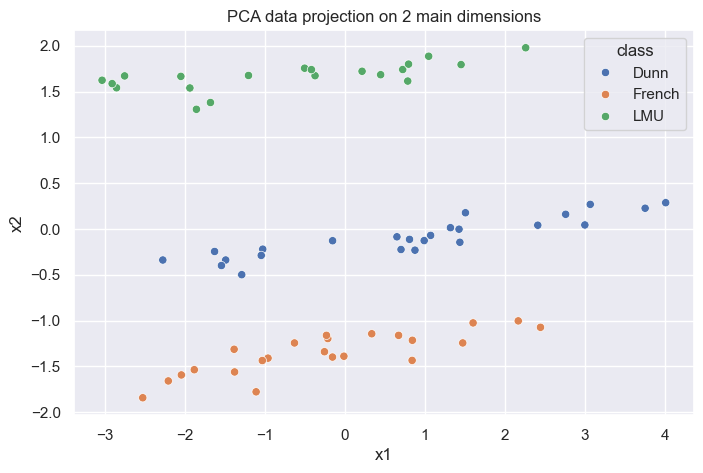

In [14]:
from sklearn.decomposition import PCA

df = df_data_process[['feature', 'log_intensity', 'sample', 'class']].groupby(['class','sample','feature']).first().unstack()
pca_2d = PCA(n_components=2)
X = df.to_numpy()
X_new = pca_2d.fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_new, columns=['x1', 'x2'])
df_plot['class'] = [c for (c, i) in df.index]

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')
fig.set_title('PCA data projection on 2 main dimensions')

In [15]:
df_X = df_data_process[['sample','feature', 'log_intensity', 'class']].pivot(index=['sample', 'class'], columns='feature', values='log_intensity').reset_index()
X = df_X.drop(['sample', 'class'], axis=1).to_numpy()
y = df_X['class'].apply(lambda x : ['Dunn', 'French', 'LMU'].index(x)).to_numpy()

C:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\Philippine\Documents\Job search\Isospec\isospec-internship\.venv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Philippine\AppData\Roaming\uv\python\cpython-3.11.11-windows-x86_64-none\Lib\subprocess.py"

Text(0.5, 1.0, 't-SNE data projection on 2 main dimensions')

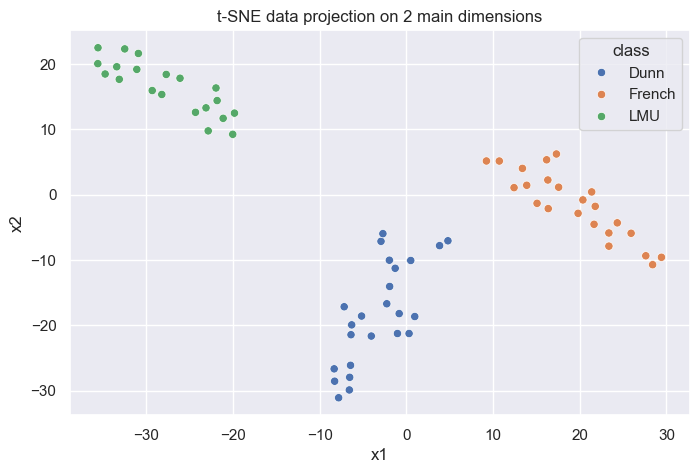

In [16]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=7).fit_transform(X)

sns.set(rc = {'figure.figsize':(8, 5)})
df_plot = pd.DataFrame(X_embedded, columns=['x1', 'x2'])
df_plot['class'] = df_X['class'].to_numpy()

fig = sns.scatterplot(df_plot, x='x1', y='x2', hue='class')
fig.set_title('t-SNE data projection on 2 main dimensions')

After feature engineering and data processing, we can see clearly 3 data clusters on PCA and t-SNE projection plots.

## 5 Final selection

In [17]:
print(f"Final curated list contains {df_data_process['feature'].nunique()} features and {df_data_process['sample'].nunique()} samples.")

Final curated list contains 180 features and 67 samples.


In [18]:
print(f"Selected features are : \n{df_data_process['feature'].unique()}\n")
print(f"Selected samples are : \n{df_data_process['sample'].unique()}")

Selected features are : 
['FT-002' 'FT-004' 'FT-005' 'FT-006' 'FT-007' 'FT-008' 'FT-009' 'FT-010'
 'FT-011' 'FT-012' 'FT-014' 'FT-015' 'FT-016' 'FT-017' 'FT-018' 'FT-019'
 'FT-020' 'FT-021' 'FT-022' 'FT-023' 'FT-024' 'FT-025' 'FT-026' 'FT-027'
 'FT-028' 'FT-029' 'FT-030' 'FT-031' 'FT-032' 'FT-033' 'FT-034' 'FT-035'
 'FT-036' 'FT-037' 'FT-038' 'FT-039' 'FT-040' 'FT-041' 'FT-042' 'FT-043'
 'FT-044' 'FT-045' 'FT-046' 'FT-048' 'FT-049' 'FT-050' 'FT-052' 'FT-053'
 'FT-054' 'FT-055' 'FT-056' 'FT-057' 'FT-058' 'FT-059' 'FT-061' 'FT-062'
 'FT-063' 'FT-064' 'FT-066' 'FT-067' 'FT-069' 'FT-070' 'FT-073' 'FT-074'
 'FT-075' 'FT-076' 'FT-077' 'FT-078' 'FT-080' 'FT-081' 'FT-082' 'FT-083'
 'FT-084' 'FT-085' 'FT-087' 'FT-088' 'FT-089' 'FT-092' 'FT-093' 'FT-095'
 'FT-096' 'FT-098' 'FT-099' 'FT-100' 'FT-101' 'FT-102' 'FT-103' 'FT-104'
 'FT-105' 'FT-107' 'FT-109' 'FT-110' 'FT-111' 'FT-112' 'FT-113' 'FT-114'
 'FT-117' 'FT-118' 'FT-119' 'FT-121' 'FT-122' 'FT-123' 'FT-124' 'FT-127'
 'FT-128' 'FT-129' 'FT-130

## 6 - Feature selection 

In [19]:
df_X = df_data_process[['sample','feature', 'log_intensity', 'class']].pivot(index=['sample', 'class'], columns='feature', values='log_intensity').reset_index()
X = df_X.drop(['sample', 'class'], axis=1).to_numpy()
y = df_X['class'].apply(lambda x : ['Dunn', 'French', 'LMU'].index(x)).to_numpy()

### 6.1 - Mutual information 

Mutual information (MI) between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency. [See link.](https://scikit-learn.org/1.5/modules/generated/sklearn.feature_selection.mutual_info_classif.html#sklearn.feature_selection.mutual_info_classif)

Here we rank features based on their mutual information with the the target, ie. the sample class.

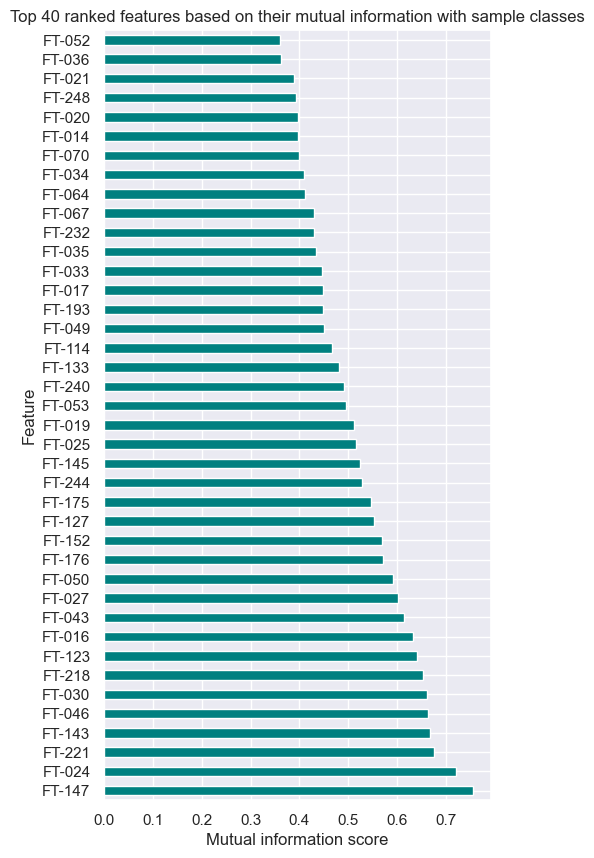

In [20]:
importances = mutual_info_classif(X, y, random_state=42)
feat_importances = pd.Series(importances, df_X.drop(['sample', 'class'], axis=1).columns)
feat_importances.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', figsize=(5,10))
plt.xlabel('Mutual information score')
plt.ylabel('Feature')
plt.title('Top 40 ranked features based on their mutual information with sample classes')
plt.show()

### 6.2 Classification with Random Forest and features ranking

We should pay attention to overfitting, since we have a small high-dimentional dataset:
* decreasing max_depth and increasing min_samples_leaf
* setting max_features to sqrt(nb_features).

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
param_grid = {
    "n_estimators": [5, 10, 15, 20, 25, 30],
    "max_depth": [3,4,5],
    "min_samples_leaf": [4,5,6,7,8],
    "max_features":['sqrt'],
    "bootstrap": [True]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='balanced_accuracy')
grid_search.fit(X, y)
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 25}
Best score: 0.9861111111111112


In [56]:
best_model = RandomForestClassifier(**best_params, random_state=42, oob_score=True)
best_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=3, min_samples_leaf=4, n_estimators=25,
                       oob_score=True, random_state=42)

In [57]:
y_pred = best_model.predict(X_test)
print('Classification report :\n', classification_report(y_test, y_pred,\
                                                        target_names=['Dunn', 'French', 'LMU']))
print('Confusion matrix :\n', confusion_matrix(y_test, y_pred))

Classification report :
               precision    recall  f1-score   support

        Dunn       0.86      1.00      0.92         6
      French       1.00      0.80      0.89         5
         LMU       1.00      1.00      1.00         3

    accuracy                           0.93        14
   macro avg       0.95      0.93      0.94        14
weighted avg       0.94      0.93      0.93        14

Confusion matrix :
 [[6 0 0]
 [1 4 0]
 [0 0 3]]


In [58]:
top_n = 40
importances = best_model.feature_importances_
features = df_X.drop(['sample', 'class'], axis=1).columns
feat_importances_rf = pd.Series(importances, features)

### 6.3 Features importance visualisation

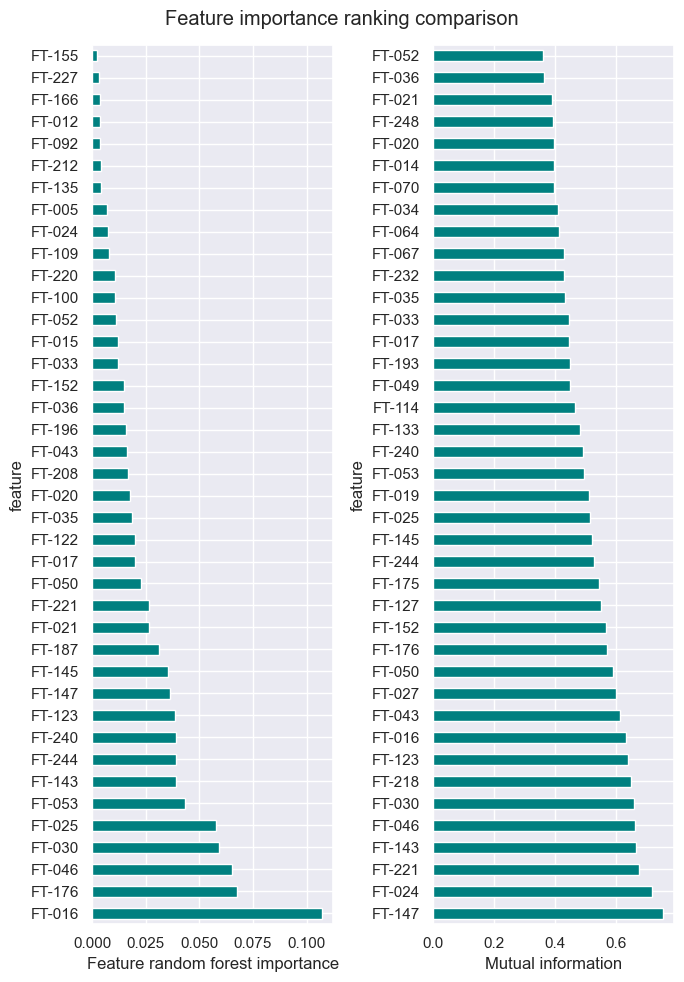

In [46]:
fig, axs = plt.subplots(ncols=2, figsize=(7,10))
feat_importances_rf.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', ax=axs[0])
axs[0].set_xlabel('Feature random forest importance')
feat_importances.sort_values(ascending=False).head(40).plot(kind='barh', color = 'teal', ax=axs[1])
axs[1].set_xlabel('Mutual information')
plt.suptitle('Feature importance ranking comparison')
plt.tight_layout()

We end up with an accuracy of 0.93 on the test dataset, with precisions (fraction of relevant instances among retrieved instances) of 1 for French (Lung cancer) and Dunn (Healthy), and .86 for LMU (Benign disease). 

Below we plot the top-5 features intensity distributions for the three classes and the two methods.

Text(0.5, 1.0, 'Top 5 discriminative features distribution')

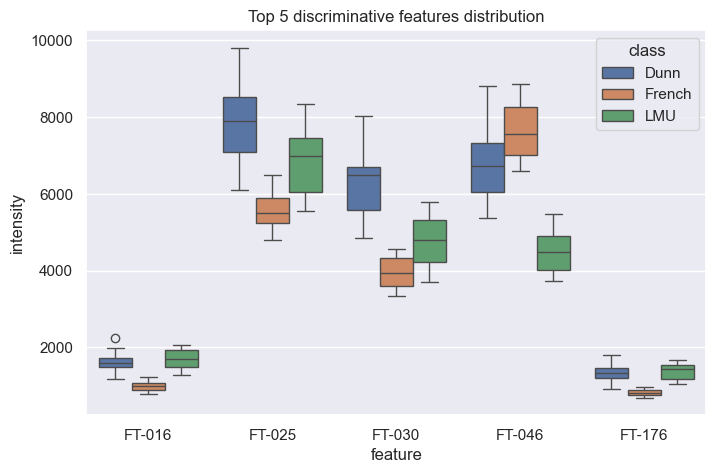

In [53]:
fig = sns.boxplot(df_data_process[df_data_process['feature_number'].isin([16,176,46,30,25])], x='feature', y='intensity', hue='class')
fig.set_title('Random-Forest-top-5 discriminative features distribution')

Assuming normal distribution, independent samples and equal variance, from above plots :

In [66]:
from scipy.stats import ttest_ind

p_val = 0.05/3 # Because we have multiple comparisons
print(f"Multiple comparison pvalue = {p_val}")

for feat in [16,176,46,30,25]:
    a = df_data_process[(df_data_process['feature_number'] == feat) & (df_data_process['class'] == 'Dunn')]['intensity']
    b = df_data_process[(df_data_process['feature_number'] == feat) & (df_data_process['class'] == 'French')]['intensity']
    c = df_data_process[(df_data_process['feature_number'] == feat) & (df_data_process['class'] == 'LMU')]['intensity']
    test_1 = ttest_ind(a,b)
    test_2 = ttest_ind(a,c)
    test_3 = ttest_ind(b,c)

    print(f"For feature {feat}:\n")
    print(f"p-value when performing Student t test between Dunn & French = {test_1.pvalue}\n")
    print(f"p-value when performing Student t test between Dunn & LMU = {test_2.pvalue}\n")
    print(f"p-value when performing Student t test between LMU & French = {test_3.pvalue}\n")
    print("-"*60, '\n')

    

Multiple comparison pvalue = 0.016666666666666666
For feature 16:

p-value when performing Student t test between Dunn & French = 1.821674057470278e-14

p-value when performing Student t test between Dunn & LMU = 0.3654970134147839

p-value when performing Student t test between LMU & French = 6.900283730821276e-16

------------------------------------------------------------ 

For feature 176:

p-value when performing Student t test between Dunn & French = 4.544915089256222e-14

p-value when performing Student t test between Dunn & LMU = 0.5418570962486595

p-value when performing Student t test between LMU & French = 1.3616860528519496e-14

------------------------------------------------------------ 

For feature 46:

p-value when performing Student t test between Dunn & French = 0.0018097228739033114

p-value when performing Student t test between Dunn & LMU = 1.7127818775443805e-12

p-value when performing Student t test between LMU & French = 2.435403382246464e-19

--------------

After t-test, we can assess that except for features 16 and 176, intensities distribution are distinct for the three classes.

Text(0.5, 1.0, 'Mutual-information-top-5 discriminative features distribution')

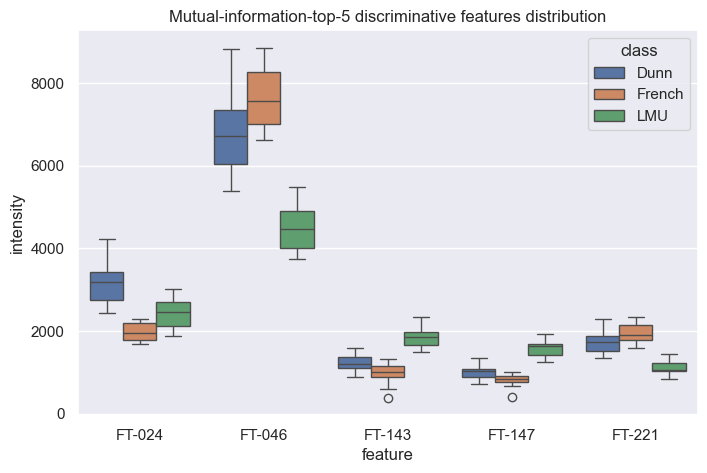

In [55]:
fig = sns.boxplot(df_data_process[df_data_process['feature_number'].isin([147, 24, 221,143,46])], x='feature', y='intensity', hue='class')
fig.set_title('Mutual-information-top-5 discriminative features distribution')

### 6.4 Next steps

This was a general discriminative feature ranking. We could in further steps implement shapley values on random forest prediction to see the most important features in a class-wise prediction manner.